In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import torch
from VAE_cell import Autoencoder, ConvolutionalVAE

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:

# Load image, grayscale, Otsu's threshold
image = cv2.imread('1f8f08ea-b5b3-4f68-94d4-3cc071b7dce8.png')
Path_bagOfCells = 'filter_extracted_cells/'
Path_patchedimage = 'patched_examples/'
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = 255 - gray
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Morph open to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

cnts_length = len(cnts)
bbox_array = np.zeros([4, cnts_length])
overlapped_check_array = np.ones([cnts_length, ], dtype='int32')

# first store the bbox coordinate
for i, c in enumerate(cnts):
    x, y, w, h = cv2.boundingRect(c)  # bounding box parameters
    bbox_array[:, i] = np.array([x, y, w, h])

# calculate the relateive size of the bbox
bbox_h_var = np.var(bbox_array[3, :])
bbox_w_var = np.var(bbox_array[2, :])
bbox_h_mean = np.mean(bbox_array[3, :])
bbox_w_mean = np.mean(bbox_array[2, :])

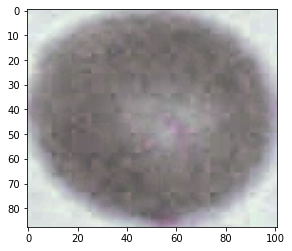

In [61]:
# Select cell
c_example = cnts[18]
x, y, w, h = cv2.boundingRect(c_example)  # bounding box location in the picture
plt.imshow(image[y:y+h, x:x+w])

In [62]:
order_dict = torch.load("./vae_cell_conv.pt", map_location=device)
model = ConvolutionalVAE(imgChannels=3)
model.load_state_dict(order_dict)
model.to(device)

ConvolutionalVAE(
  (encConv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (encFC1): Linear(in_features=430592, out_features=20, bias=True)
  (encFC2): Linear(in_features=430592, out_features=20, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (decFC1): Linear(in_features=20, out_features=430592, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 3, kernel_size=(7, 7), stride=(1, 1))
)

In [63]:
original_patch = cv2.resize(image[y:y+h, x:x+w], (128, 128))
original_patch = original_patch/255
original_patch = original_patch.transpose(2, 0, 1)
original_patch = original_patch.reshape((1,3,128,128))


In [64]:
out, mu, logVAR = model(torch.tensor(original_patch).float().to(device))
outimg = out.detach().to('cpu').numpy().reshape((3, 128, 128))

In [66]:
outimg = np.array(outimg.transpose(1,2,0) * 255, dtype="uint8")

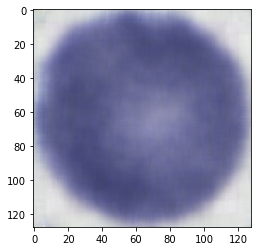

In [67]:
plt.imshow(outimg)

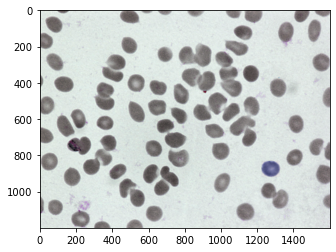

In [68]:
# example find one of the bbox and replace it with a patch
# c_example = cnts[20]
# x, y, w, h = cv2.boundingRect(c_example)  # bounding box location in the picture
cell_image = cv2.resize(outimg, (w, h))
patched_image = original.copy()
patched_image[y:y + h, x:x + w] = cell_image

plt.imshow(patched_image)

# cv2.imwrite(Path_patchedimage + 'original_{}.png'.format(cell_image_name), original)
# cv2.imwrite(Path_patchedimage + 'patched_{}.png'.format(cell_image_name), patched_image)

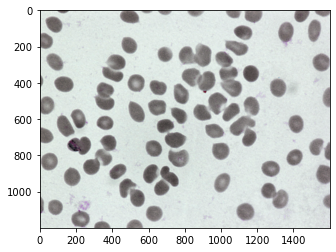

In [81]:
plt.imshow(original)

In [82]:
print(x,y)

708 769
